# Исследование надежности заемщиков.

# Описание проекта

 Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов. Результаты исследования будут учтены при построении модели кредитного скоринга — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

 
 **Цель исследования** — проверьте две гипотезы:
1. Семейное положение влияет на погашение кредита в срок
2. Наличие детей так же влияет.

3. (Дополнительно хочу проверить как влияют остальные факторы, ведь любой показатель может иметь значение, хоть это и не являеться основной задачей, я думаю это будет интересно ;)

**Ход исследования**

О данных ничего не известно. Поэтому перед проверкой гипотез понадобится обзор данных. После оценки данных на ошибки, я оценю влияют-ли они на исследование или нет, если да, то выполню предобработку. Так же может потребоваться провести категоризацию.

 Таким образом, исследование пройдёт в три этапа:
 1. Обзор данных.
 2. Предобработка данных, которая включает: 
 * проверка на пропуски
 * дубликаты
 * ошибки и аномалии
 * а так же категаризация данных.
 3. Проверка гипотез путём сравнения с средним показанием столбца 'debt'.
 4. Так же я хочу проскорить таблицу и проверить насколько сильно влияют эти факторы.

In [1]:
!pip install catboost

     -------------------------------------- 74.0/74.0 MB 273.1 kB/s eta 0:00:00
     -------------------------------------- 47.0/47.0 kB 261.0 kB/s eta 0:00:00


In [2]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


### Шаг 1. Обзор данных

In [3]:
import pandas as pd
import numpy as np
import time
from pymystem3 import Mystem
m = Mystem()
from collections import Counter

from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_recall_curve, f1_score

from sklearn.linear_model import LogisticRegression as LR, RidgeClassifier as RC, Ridge
from sklearn.tree import DecisionTreeClassifier as DTC
from catboost import Pool, CatBoostClassifier as CBC, cv

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
#plt.style.use('default')
plt.style.use('dark_background') # я работаю в темной теме, поэтому использую эту настройку.
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

s = 121222

In [4]:
df = pd.read_csv('data.csv')
df.sample(5)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
18796,0,-6151.958617,35,высшее,0,женат / замужем,0,F,компаньон,0,168095.393688,операции с жильем
3514,0,-851.985464,31,среднее,1,женат / замужем,0,F,сотрудник,0,102550.896821,покупка жилой недвижимости
16838,0,-570.967837,52,среднее,1,женат / замужем,0,M,компаньон,0,128851.599074,сделка с подержанным автомобилем
8299,2,-2262.323747,39,среднее,1,женат / замужем,0,M,компаньон,0,967425.422855,свой автомобиль
14651,0,NaN,23,высшее,0,гражданский брак,1,F,сотрудник,0,NaN,ремонт жилью


In [5]:
df.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21525.000000,19351.000000,21525.000000,21525.000000,21525.000000,21525.000000,1.935100e+04
mean,0.538908,63046.497661,43.293380,0.817236,0.972544,0.080883,1.674223e+05
std,1.381587,140827.311974,12.574584,0.548138,1.420324,0.272661,1.029716e+05
min,-1.000000,-18388.949901,0.000000,0.000000,0.000000,0.000000,2.066726e+04
25%,0.000000,-2747.423625,33.000000,1.000000,0.000000,0.000000,1.030532e+05
50%,0.000000,-1203.369529,42.000000,1.000000,0.000000,0.000000,1.450179e+05
75%,1.000000,-291.095954,53.000000,1.000000,1.000000,0.000000,2.034351e+05
max,20.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,2.265604e+06


В столбце days_emploeyd максимальный стаж больше 100 лет (возможно там имеются ввиду часы?), при том что максимальный возраст в таблице 75 лет, да и ещё и куча отрицательных значений, по нему одназначно стоит дать баг-репорт. Я изучу его подробнее ниже, и посмотрю, что можно с этим сделать в таком виде.

Следующие аномалия - количество детей от минус 1 до 20. Первое не может быть, возможно, что информация о детях не известна, либо так неправильно отобразился 1 ребёнок или 0. А 20 детей выглядит странно. Посмотрим подробнее.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


В days_employed и total_income одинаковое количество пропусков, вероятно в одних и тех же строках. Нужно будет привести их в порядок, особенно total_income.

Посмотрим на долю должников до предобработки - это значение для данного исследования.

In [7]:
df['debt'].mean() 

0.08088269454123112

### Шаг 2.1 Заполнение пропусков

In [8]:
df.isna().mean() #проверка пропущенных значений

children            0.000000
days_employed       0.100999
dob_years           0.000000
education           0.000000
education_id        0.000000
family_status       0.000000
family_status_id    0.000000
gender              0.000000
income_type         0.000000
debt                0.000000
total_income        0.100999
purpose             0.000000
dtype: float64

Доля пропусков достаточно большая, поэтому не буду их удалять.

Разбремся с days_employed и total_income, посмотрим в каких значениях пропуски. Возможно так забаговал  какой-нибудь тип клиента к примеру "пенсионер" или любой другой параметр.

In [9]:
df.loc[(df['days_employed'].isna()) & (df['total_income'].isna()),'dob_years'].count()
#подсчет пропущенных значений в обох столбцах вместе

2174

In [10]:
df.loc[(df['days_employed'].isna()) & (df['total_income'].isna())].head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
12,0,NaN,65,среднее,1,гражданский брак,1,M,пенсионер,0,NaN,сыграть свадьбу
26,0,NaN,41,среднее,1,женат / замужем,0,M,госслужащий,0,NaN,образование
29,0,NaN,63,среднее,1,Не женат / не замужем,4,F,пенсионер,0,NaN,строительство жилой недвижимости
41,0,NaN,50,среднее,1,женат / замужем,0,F,госслужащий,0,NaN,сделка с подержанным автомобилем
55,0,NaN,54,среднее,1,гражданский брак,1,F,пенсионер,1,NaN,сыграть свадьбу
65,0,NaN,21,среднее,1,Не женат / не замужем,4,M,компаньон,0,NaN,операции с коммерческой недвижимостью
67,0,NaN,52,высшее,0,женат / замужем,0,F,пенсионер,0,NaN,покупка жилья для семьи
72,1,NaN,32,высшее,0,женат / замужем,0,M,госслужащий,0,NaN,операции с коммерческой недвижимостью
82,2,NaN,50,высшее,0,женат / замужем,0,F,сотрудник,0,NaN,жилье
83,0,NaN,52,среднее,1,женат / замужем,0,M,сотрудник,0,NaN,жилье


Никакой закономерности нет, заменю пропуски в total_income на медийное значение по каждому виду дохода, так данные будут максимально близки к исходным.

In [11]:
income_category = df.groupby('income_type')['total_income'].median()

In [12]:
income_category

income_type
безработный        131339.751676
в декрете           53829.130729
госслужащий        150447.935283
компаньон          172357.950966
пенсионер          118514.486412
предприниматель    499163.144947
сотрудник          142594.396847
студент             98201.625314
Name: total_income, dtype: float64

In [13]:
df['total_income'] = df['total_income'].fillna(df.groupby('income_type')['total_income'].transform("median"))

In [14]:
df['total_income'].isna().sum() #проверяю

0

### Шаг 2.2 Проверка данных на аномалии и исправления.

Здесь я проверю каждый столбец и посмотрю есть-ли там какие-нибудь аномалии и странности.

In [15]:
df['days_employed'].describe()

count     19351.000000
mean      63046.497661
std      140827.311974
min      -18388.949901
25%       -2747.423625
50%       -1203.369529
75%        -291.095954
max      401755.400475
Name: days_employed, dtype: float64

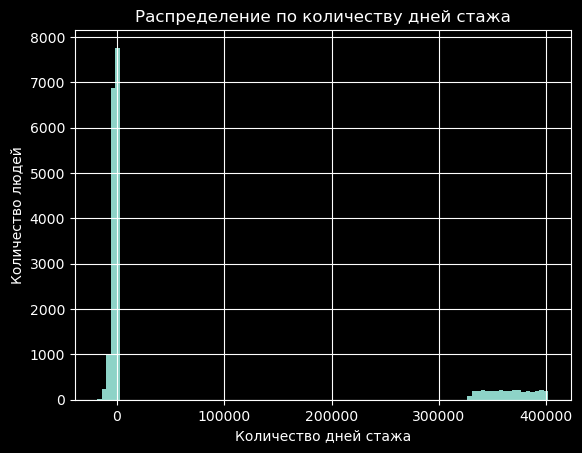

In [16]:
df['days_employed'].hist(bins=100)
plt.title('Распределение по количеству дней стажа')
plt.ylabel('Количество людей')
plt.xlabel('Количество дней стажа')
plt.show()

In [17]:
print('Количество лет стажа у тех у кого более 300_000 дней')
print('300000:', 300000/365)
print('400000:', 400000/365)
print('Количество лет стажа у тех у кого более 300_000 часов')
print('300000:', 300000/24/365)
print('400000:', 400000/24/365)

Количество лет стажа у тех у кого более 300_000 дней
300000: 821.917808219178
400000: 1095.890410958904
Количество лет стажа у тех у кого более 300_000 часов
300000: 34.24657534246575
400000: 45.662100456621005


Огромное количество значений меньше или равно нулю, так же есть большая часть в диопазоне от 300000 до 400000 рабочих дней стажа, а это целых как минимум 800 лет, а то и все 1100. Вероятно сюда по ошибке занесли рабочие часы вместо дней, если разделить на 24, то стаж уже будет более реальный 35-45 лет. А отрицательные числа переведу по модулю в положительные.

In [18]:
def to_pozitive(value):
    if value < 0:
        value *= -1
        return value
    else:
        return value
    
df['days_employed'] = df['days_employed'].apply(to_pozitive)

In [19]:
df['days_employed'].describe()

count     19351.000000
mean      66914.728907
std      139030.880527
min          24.141633
25%         927.009265
50%        2194.220567
75%        5537.882441
max      401755.400475
Name: days_employed, dtype: float64

Теперь поделим на 24 значения, которые больше 23775 (это 60 лет стажа - макисмальный возраст в таблице 75, больше уже никак не может быть.).
И затем заменим пропуски на медийное значение по каждому виду дохода.

In [20]:
df['days_employed']= df['days_employed'].mask( df['days_employed'] > 23775, df['days_employed']/ 24)
df['days_employed'] = df['days_employed'].fillna(df.groupby('income_type')['days_employed'].transform("median"))

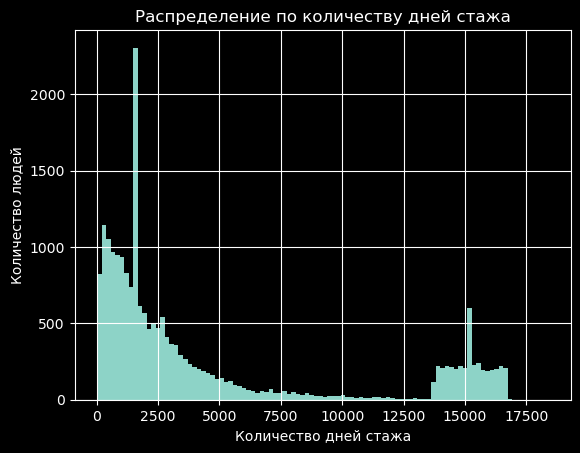

In [21]:
df['days_employed'].hist(bins=100)
plt.title('Распределение по количеству дней стажа')
plt.ylabel('Количество людей')
plt.xlabel('Количество дней стажа')
plt.show()

Стало получше, график хоть и не пришёл в нормальное распределение, но зато стал больше походить на правду. Так ка природа аномалии точно не ясна, то я оставлю эти данные в таком виде. Стоит указать про этот столбец в баг-репорте.

In [22]:
df['days_employed'].describe()

count    21525.000000
mean      4600.535795
std       5354.354167
min         24.141633
25%       1025.549623
50%       1993.522017
75%       5347.024506
max      18388.949901
Name: days_employed, dtype: float64

In [23]:
df['children'].value_counts()

 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

Проверим, что происходить в строках с аномальными значениями и есть-ли закономрности.

In [24]:
df[df['children']==-1].sample(5)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
21140,-1,1422.668059,44,среднее,1,женат / замужем,0,F,компаньон,0,169562.091999,операции со своей недвижимостью
11617,-1,370.827130,27,среднее,1,женат / замужем,0,F,компаньон,0,164591.260338,покупка жилья для сдачи
20717,-1,661.822321,32,высшее,0,женат / замужем,0,F,сотрудник,0,137405.384917,покупка жилой недвижимости
7615,-1,1574.202821,35,среднее,1,женат / замужем,0,M,сотрудник,0,142594.396847,образование
4402,-1,16583.387620,64,СРЕДНЕЕ,1,женат / замужем,0,F,пенсионер,0,163264.062064,покупка недвижимости


In [25]:
df[df['children']==20].sample(5)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
3697,20,2907.910616,40,среднее,1,гражданский брак,1,M,сотрудник,0,115380.694664,на покупку подержанного автомобиля
12319,20,507.160088,50,Среднее,1,гражданский брак,1,M,компаньон,1,169780.898628,на проведение свадьбы
12212,20,11937.171389,57,среднее,1,женат / замужем,0,F,сотрудник,0,133198.384897,строительство жилой недвижимости
15762,20,4744.140679,41,среднее,1,женат / замужем,0,F,сотрудник,0,143529.459627,дополнительное образование
11489,20,519.638567,34,среднее,1,женат / замужем,0,F,сотрудник,0,389841.083378,покупка жилой недвижимости


Закономерностей не вижу, поэтому строки с количеством детей -1 я удалю, потому что неизвестно как они возникли. А 20 поменяю на медийное значение, потому что вероятно это 0 или 2 - на кавиатуре они рядом. Так как количество аномалий меньше процента, то такие изменения на анализ сильно не повлияют.

In [26]:
for str in df[df['children']==-1].index:
        df = df.drop(str)

In [27]:
df['children'] = df['children'].replace(20, df.loc[df.loc[:, 'children'] != 20]['children'].median())

In [28]:
df['children'].value_counts() # проверяем.

0    14225
1     4818
2     2055
3      330
4       41
5        9
Name: children, dtype: int64

Здесь разобрались! Теперь проверим другие столбцы, начнем с гендера.

In [29]:
df['gender'].value_counts()

F      14201
M       7276
XNA        1
Name: gender, dtype: int64

В принципе один человек особо роли не играет, можно оставить как есть.

In [30]:
df['education'].value_counts()

среднее                13719
высшее                  4710
СРЕДНЕЕ                  768
Среднее                  709
неоконченное высшее      667
ВЫСШЕЕ                   273
Высшее                   268
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
Ученая степень             1
УЧЕНАЯ СТЕПЕНЬ             1
Name: education, dtype: int64

Привожу к нижнем регистру.

In [31]:
df['education'] = df['education'].str.lower()

In [32]:
df['education'].value_counts() #проверяю

среднее                15196
высшее                  5251
неоконченное высшее      743
начальное                282
ученая степень             6
Name: education, dtype: int64

Порядок!

In [33]:
df['family_status'].value_counts()

женат / замужем          12351
гражданский брак          4172
Не женат / не замужем     2808
в разводе                 1191
вдовец / вдова             956
Name: family_status, dtype: int64

Здесь всё в порядке

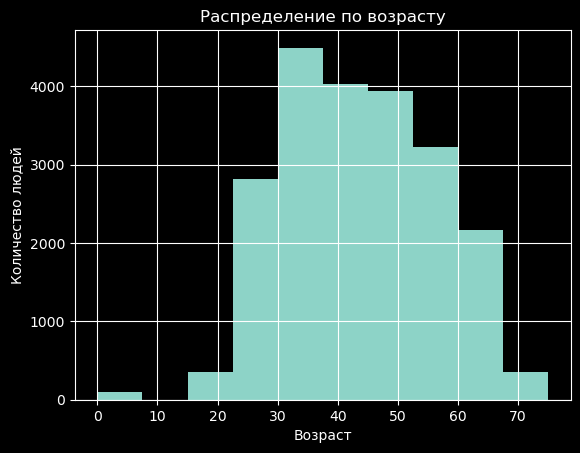

In [34]:
df['dob_years'].hist()
plt.title('Распределение по возрасту')
plt.ylabel('Количество людей')
plt.xlabel('Возраст')
plt.show()

In [35]:
df[df['dob_years']<18]['dob_years'].value_counts()

0    101
Name: dob_years, dtype: int64

Присутствует аномальное значение 0. Закономерностей нет, поэтому удалю эти значения.

In [36]:
for d in df[df['dob_years']==0].index:
    df = df.drop(d)
    
df = df.reset_index(drop=True)

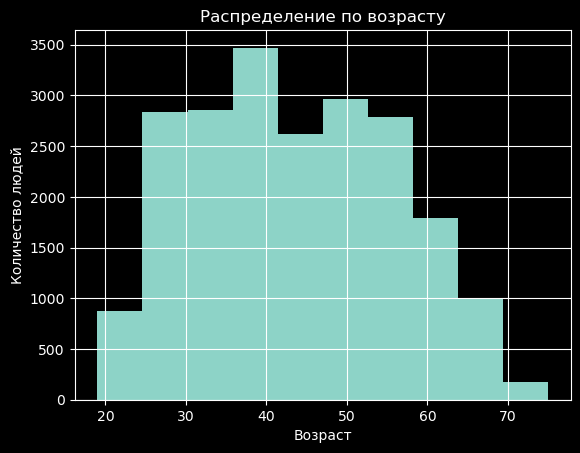

In [37]:
df['dob_years'].hist() #проверяю
plt.title('Распределение по возрасту')
plt.ylabel('Количество людей')
plt.xlabel('Возраст')
plt.show()

Всё нормально.

In [38]:
df['debt'].value_counts()

0    19645
1     1732
Name: debt, dtype: int64

Всё в порядке.

In [39]:
df['purpose'].value_counts()

свадьба                                   792
на проведение свадьбы                     772
сыграть свадьбу                           768
операции с недвижимостью                  671
покупка коммерческой недвижимости         661
покупка жилья для сдачи                   650
операции с коммерческой недвижимостью     648
операции с жильем                         646
покупка жилья для семьи                   640
жилье                                     640
покупка жилья                             638
строительство собственной недвижимости    632
недвижимость                              629
операции со своей недвижимостью           627
строительство недвижимости                620
строительство жилой недвижимости          620
покупка своего жилья                      618
покупка недвижимости                      618
ремонт жилью                              609
покупка жилой недвижимости                602
на покупку своего автомобиля              501
заняться высшим образованием      

Явно требуется леммитизация (привидение к одному названию).

### Шаг 2.3. Изменение типов данных.

Привожу к целочисленому типу.

In [40]:
df['days_employed'] = df['days_employed'].astype('int')
df['total_income'] = df['total_income'].astype('int')

### Шаг 2.4. Удаление дубликатов.

In [41]:
df.duplicated().sum()

71

In [42]:
df[df.duplicated(keep=False)].sort_values(by=['total_income'])

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
21267,0,15217,54,среднее,1,женат / замужем,0,F,пенсионер,0,118514,операции с жильем
6495,0,15217,71,среднее,1,гражданский брак,1,F,пенсионер,0,118514,на проведение свадьбы
6631,0,15217,64,среднее,1,гражданский брак,1,F,пенсионер,0,118514,сыграть свадьбу
6830,0,15217,62,среднее,1,женат / замужем,0,F,пенсионер,0,118514,получение дополнительного образования
7260,0,15217,64,высшее,0,гражданский брак,1,F,пенсионер,0,118514,на проведение свадьбы
...,...,...,...,...,...,...,...,...,...,...,...,...
15873,0,1547,51,среднее,1,гражданский брак,1,F,компаньон,0,172357,на проведение свадьбы
10619,0,1547,40,среднее,1,гражданский брак,1,F,компаньон,0,172357,сыграть свадьбу
5088,0,1547,40,среднее,1,гражданский брак,1,F,компаньон,0,172357,сыграть свадьбу
13774,1,1547,31,среднее,1,женат / замужем,0,F,компаньон,0,172357,покупка жилья


 Дубликаты тоже требуют запроса, возможно один и тот же человек брал кредит несколько раз или же закрался какой-то баг, а может кто-то из работников несколько раз вносил одни и те же данные.

 Так как дубликатов мало я их удалю.

In [43]:
df = df.drop_duplicates()

In [44]:
df.duplicated().sum()

0

### Шаг 2.5. Формирование дополнительных датафреймов словарей, декомпозиция исходного датафрейма.

Здесь я начну рассматривать каждый столбец в сравнении с 'debt' и делать скоринг для наглядности исследвания. Попутно сделаю леммитизацию столбца 'purpuse' и категоризацию 'total_income'.

Посмотрим какой средний процент должников в выборке.

In [45]:
df['debt'].mean() #средний процент должников после обработки

0.08129165493288276

Примерно 8,1% на него и будем ориентироваться. Посмотрим есть-ли зависимость между debt и количеством детей.

In [46]:
df.groupby('children')['debt'].agg(['count','mean']) 

,count,mean
children,,
0,14097,0.075619
1,4792,0.092028
2,2039,0.095145
3,328,0.082317
4,41,0.097561
5,9,0.000000


In [47]:
(0.092028 - 0.075619)/0.092028
#сравниваю две самые весомые категории - нет детей и 1 ребёнок.

0.1783044290867996

Разница почти 18%! А это очень значимое различие, в банковском деле отклонениее более 1% уже показатель.
В целом здесь можно выделить две основные категории и обобщить выборку - "есть дети" и "нет детей", так как основное различие именно видно именно здесь.

In [48]:
df['has_children'] = (df['children'] > 0) *1
df.groupby('has_children')['debt'].agg(['count','mean']) 

,count,mean
has_children,,
0,14097,0.075619
1,7209,0.092385


Красота! Никакого шума, а сам показатель очень чёткий и понятный. В скор-поинты у меня пойдут более негативные варианты, у которых 'debt' выше. В скоринге чем болше score, тем больше долже быть средний 'debt'

In [49]:
df.groupby('education')['debt'].agg(['count','mean']) #рассмотрим тоже самое для графы "Образование"

,count,mean
education,,
высшее,5206,0.053208
начальное,282,0.109929
неоконченное высшее,741,0.091768
среднее,15071,0.089974
ученая степень,6,0.000000


Здесь так же можно выделить и обобщить две большие категории - есть высшее образование или нет.

In [50]:
df['no_higher_education'] = ~df['education'].isin(['высшее','ученая степень']) *1
df.groupby('no_higher_education')['debt'].agg(['count','mean'])
# 0 - есть высшее, 1 - нет высшего.

,count,mean
no_higher_education,,
0,5212,0.053147
1,16094,0.090406


Здесь специально я вывожу категории с более высокой задолжностью (плохой) под значение 1, а более низкой под значение(хорошей) 0. Это позволит нам заскорить каждого клиента. Гипотиза - чем выше показетель score, тем более высокий шанс задолжности.

In [51]:
df['score'] = df['has_children'] + df['no_higher_education'] # создаем столбец 'score'
df.groupby('score')['debt'].agg(['count','mean']) #проверяем

,count,mean
score,,
0,3254,0.052858
1,12801,0.078041
2,5251,0.106837


Так оно и есть!
Теперь рассмотрим зависимость от возроста, так как категорий много нагляднее будет зделать график.

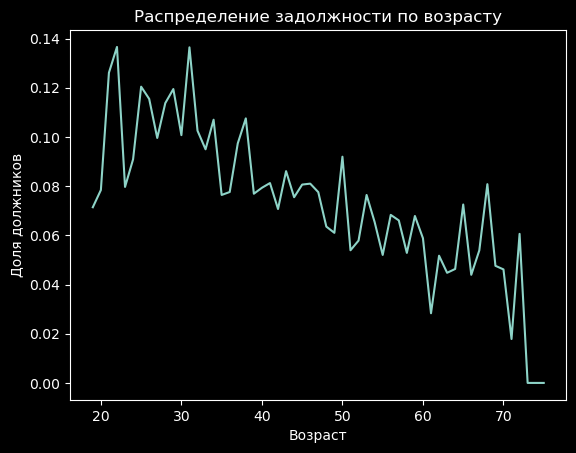

In [52]:
df.groupby('dob_years')['debt'].mean().plot()
plt.title('Распределение задолжности по возрасту')
plt.ylabel('Доля должников')
plt.xlabel('Возраст')
plt.show()

Вывод - Чем старше человек, тем меньше шас задолжности, поэтому можно сделать ранжирование, где максимальный возраст будет ближе к 0, а минимальный к 1.

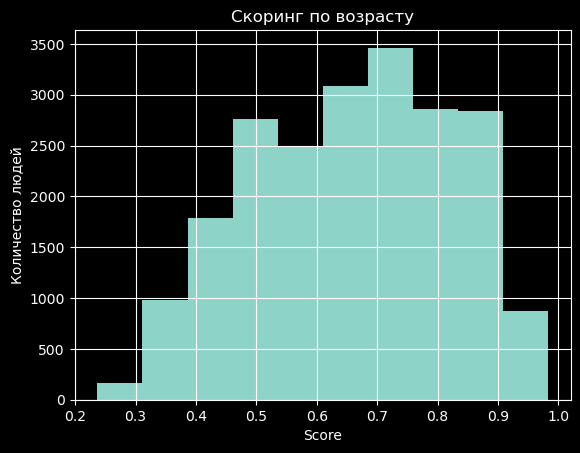

In [53]:
df['dob_years_score'] = ~df['dob_years'] / df['dob_years'].max()+1*1.25 # переведём в системе от 0 до 1
df['dob_years_score'].hist()
plt.title('Скоринг по возрасту')
plt.ylabel('Количество людей')
plt.xlabel('Score')
plt.show()

In [54]:
df.groupby('gender')['debt'].agg(['count','mean'])

,count,mean
gender,,
F,14067,0.070235
M,7238,0.102791
XNA,1,0.000000


Девушки выплачивают в срок чаще мужчин, тоже добавим в скоринг.

In [55]:
df['gender_score'] = df['gender'].isin(['M']) *1
df.groupby('gender_score')['debt'].agg(['count','mean'])

,count,mean
gender_score,,
0,14068,0.070230
1,7238,0.102791


In [56]:
df.groupby('family_status')['debt'].agg(['count','mean'])

,count,mean
family_status,,
Не женат / не замужем,2789,0.097885
в разводе,1181,0.071973
вдовец / вдова,950,0.065263
гражданский брак,4125,0.093576
женат / замужем,12261,0.075524


Видно, что те кто находиться в гражданском браке или никогда не вступал в брак хуже выплачивают долги.

In [57]:
df['family_score'] = df['family_status'].isin(['Не женат / не замужем','гражданский брак']) *1
df.groupby('family_score')['debt'].agg(['count','mean'])

,count,mean
family_score,,
0,14392,0.074555
1,6914,0.095314


In [58]:
df['score'] = df[['has_children','no_higher_education','dob_years_score','gender_score','family_score']].sum(axis=1)
df['score_round'] = df['score'].round()
df['score_q'] = pd.qcut(df['score'], 10)

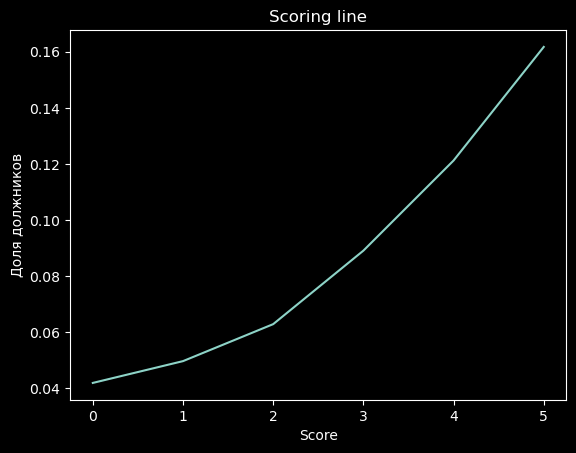

In [59]:
df.groupby('score_round')['debt'].mean().plot() # пердварительный просмотр
plt.title('Scoring line')
plt.ylabel('Доля должников')
plt.xlabel('Score')
plt.show()

In [60]:
df.groupby('score_q')['debt'].agg(['count','mean'])

,count,mean
score_q,,
"(0.249, 1.41]",2298,0.047868
"(1.41, 1.53]",1976,0.048583
"(1.53, 1.69]",2234,0.059982
"(1.69, 1.903]",2080,0.073077
"(1.903, 2.53]",2092,0.066922
"(2.53, 2.69]",2311,0.074859
"(2.69, 2.81]",2109,0.089142
"(2.81, 3.49]",1979,0.105609
"(3.49, 3.783]",2240,0.111161


Пока закономерность прослеживается, посмотрим что будет с последими двумя категориями - доходом и целью кредита.

### Шаг 2.6. Категоризация дохода.

In [61]:
df['total_income'].describe()

count    2.130600e+04
mean     1.653872e+05
std      9.835419e+04
min      2.066700e+04
25%      1.076325e+05
50%      1.425940e+05
75%      1.958368e+05
max      2.265604e+06
Name: total_income, dtype: float64

In [62]:
df['total_income']

0        253875
1        112080
2        145885
3        267628
4        158616
          ...  
21372    224791
21373    155999
21374     89672
21375    244093
21376     82047
Name: total_income, Length: 21306, dtype: int32

Для удобства произведу округление дохода до 1000.

In [63]:
total_income_q = df['total_income']/1000 # округрение дохода

In [64]:
df.groupby([pd.cut(total_income_q,10)])['debt'].agg(['count','mean'])

,count,mean
total_income,,
"(18.422, 245.161]",18370,0.083342
"(245.161, 469.654]",2649,0.069838
"(469.654, 694.148]",224,0.049107
"(694.148, 918.642]",34,0.088235
"(918.642, 1143.135]",15,0.066667
"(1143.135, 1367.629]",6,0.000000
"(1367.629, 1592.123]",2,0.000000
"(1592.123, 1816.617]",4,0.000000
"(1816.617, 2041.11]",0,NaN


Большинство находиться до миллиона, поэтому рассмотрю эту часть в гистограмме.

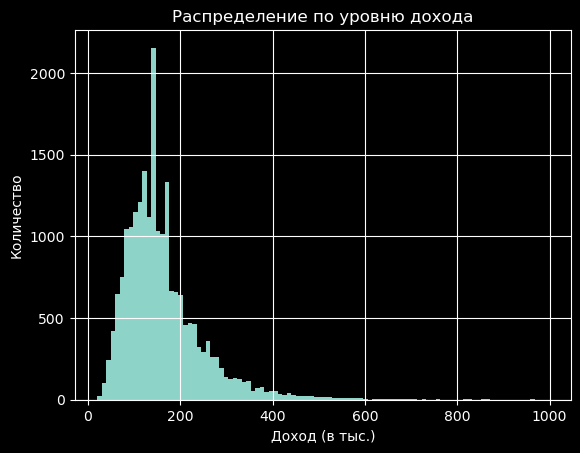

In [65]:
total_income_q.loc[total_income_q<1000].hist(bins=100)
plt.title('Распределение по уровню дохода')
plt.ylabel('Количество')
plt.xlabel('Доход (в тыс.)')
plt.show()

Поделю людей на категории дохода согласно гистограмме.
* 0 - 30000 - E
* 30000 - 50000 - D
* 50000 - 200000 - C
* 200000 - 1000000 - B
* Более 1000000 - A

In [66]:
def total_income_group(x):
    if x <= 30000:
        return 'E'
    if x <= 50000:
        return 'D'
    if x <= 200000:
        return 'C'
    if x <= 1000000:
        return 'B'
    return 'A'
    
df['total_income_category'] = df['total_income'].apply(total_income_group)   

In [67]:
df.groupby('total_income_category')['debt'].agg(['count','mean'])

,count,mean
total_income_category,,
A,25,0.080000
B,5008,0.070887
C,15904,0.085010
D,347,0.060519
E,22,0.090909


### Шаг 2.7. Категоризация целей кредита.

In [68]:
df['purpose'].value_counts() #займемся столбцом 'purpose'

свадьба                                   786
на проведение свадьбы                     763
сыграть свадьбу                           759
операции с недвижимостью                  670
покупка коммерческой недвижимости         658
покупка жилья для сдачи                   648
операции с коммерческой недвижимостью     647
операции с жильем                         645
жилье                                     639
покупка жилья                             637
покупка жилья для семьи                   637
строительство собственной недвижимости    632
недвижимость                              628
операции со своей недвижимостью           624
строительство недвижимости                619
строительство жилой недвижимости          618
покупка своего жилья                      618
покупка недвижимости                      615
ремонт жилью                              604
покупка жилой недвижимости                601
на покупку своего автомобиля              501
заняться высшим образованием      

In [69]:
%%time
m = Mystem()

columns = ['original', 'lemms', 'good']
purpose_list = pd.DataFrame(data=[],columns=columns)
purpose_list['original'] = df['purpose'].value_counts().index

for i in purpose_list.index:
    purpose_list.loc[i,'lemms'] = ' '.join(m.lemmatize(purpose_list.loc[i, 'original']))

purpose_list

Wall time: 35.4 s


,original,lemms,good
0,свадьба,свадьба \n,NaN
1,на проведение свадьбы,на проведение свадьба \n,NaN
2,сыграть свадьбу,сыграть свадьба \n,NaN
3,операции с недвижимостью,операция с недвижимость \n,NaN
4,покупка коммерческой недвижимости,покупка коммерческий недвижимость \n,NaN
5,покупка жилья для сдачи,покупка жилье для сдача \n,NaN
6,операции с коммерческой недвижимостью,операция с коммерческий недвижимость \n,NaN
7,операции с жильем,операция с жилье \n,NaN
8,жилье,жилье \n,NaN
9,покупка жилья,покупка жилье \n,NaN


Здесь видно, что имееться всего 4 цели - свадьба, недвижимость, покупка авто и образование, просто их по-разному написали.

In [70]:
%%time
lem_purpose = dict({'свадьба':'свадьба', 
                    'жилье':'недвижимость', 
                    'недвижимость':'недвижимость',
                    'автомобиль':'автомобиль', 
                    'образование':'образование'})

def replace_wrong_purpose(row):
    str_lem_list = m.lemmatize(row)
    for lem in str_lem_list:
        if lem in lem_purpose.keys():
            return lem_purpose[lem]

        
purpose_list['good'] = purpose_list['original'].apply(replace_wrong_purpose)

purpose_list #проверяю

Wall time: 35.1 s


,original,lemms,good
0,свадьба,свадьба \n,свадьба
1,на проведение свадьбы,на проведение свадьба \n,свадьба
2,сыграть свадьбу,сыграть свадьба \n,свадьба
3,операции с недвижимостью,операция с недвижимость \n,недвижимость
4,покупка коммерческой недвижимости,покупка коммерческий недвижимость \n,недвижимость
5,покупка жилья для сдачи,покупка жилье для сдача \n,недвижимость
6,операции с коммерческой недвижимостью,операция с коммерческий недвижимость \n,недвижимость
7,операции с жильем,операция с жилье \n,недвижимость
8,жилье,жилье \n,недвижимость
9,покупка жилья,покупка жилье \n,недвижимость


In [ ]:
%%time
df['purpose'] = df['purpose'].apply(replace_wrong_purpose) #заменяю
df.to_csv(r'df_new.csv', index= False )

Так как локально этот этам занимал много времени то я сохранил получившийся дф в формате csv.

In [ ]:
df = pd.read_csv('df_new.csv')

In [ ]:
df['purpose'].value_counts() #проверяю

Теперь сравним каждую категорию с debt.

In [ ]:
df.groupby('purpose')['debt'].agg(['count','mean']) 

Те кто берут кредит на образование и автомобиль возвращают их хуже.
 Присвою им score 1.

In [ ]:
pd.pivot_table(df,index='children',values='debt',aggfunc=['mean','count'])

In [ ]:
pd.pivot_table(df,index='family_status',values='debt',aggfunc=['mean','count'])

In [ ]:
df['purpose_score'] = df['purpose'].isin(['автомобиль','образование'])*1

### Теперь сложу все score-столбцы и посмотрю что получилось

In [ ]:
df['score'] = df[['has_children','no_higher_education','dob_years_score','gender_score','family_score','purpose_score']].sum(axis=1)
df['score_round'] = df['score'].round()
df['score_q'] = pd.qcut(df['score'], 20)

In [ ]:
df.groupby('score_round')['debt'].mean().plot()

In [ ]:
df['score_q'] = pd.qcut(df['score'], 20)

In [ ]:
df.groupby('score_q')['debt'].agg(['count','mean'])

 Как видно у кого score больше 2.5 в среднем имееют более высокий  шанс задолжности, но особо резкое отличное начинается с 3.5 баллов, там шанс задолжности преваливает за 11%, а после 4.5 и вовсе 17% - вдвое больше среднего значения!
 
 Те у кого скор меньше 1.5 имеют задолжности не чаще 5.1% случаев. 

**Вывод** - все параметры имеют значение.

### Ответы на вопросы.

##### Вопрос 1:  Влияет-ли семейное положение на погошение отвта в срок?

##### Вывод 1:

Да влияет, те кто находиться в гражданском браке или никогда не вступал в брак хуже выплачивают долги.

##### Вопроc 2: Влияет-ли количество детей на погошение отвта в срок?

##### Вывод 2:

Да влияет, те у кого нет детей лучше возвращают долги.

## Общий вывод:

- Практически все характеристики имееют свой вес, исключение составил доход. Как выяснилось те, кто имеет  заработок от 30001 до 50000 чаще вовращают кредиты в срок, а все остальные в пределах среднего значения. Вот что получаеться по каждому параметру:

- Чем старше человек тем меньше шанс просрочки.
- Те у кого нет детей возращают лучше,чем тем у кого есть.
- Люди с высшим образованием возвращают долги почти вдвое чаще, чем те у кого нет высшего.
- Те кто находиться в гражданском браке или никогда не вступал в брак хуже выплачивают долги.
- Те кто берут кредит на недвижимость и свадьбу, чаще возращают.
- Женщины возращают долги чаще мужчин.

- Выводы сделаны по предоставленным данным, если выборка будет больше выводы могут измениться. 
- Сейчас у нас получаеться что **лучшее кредиторы** это : овдовевшие (или хотя бы просто в разводе, но и замужние попрут) женщины после 50, без детей, с высшим образванием, которые берут кредит на свадьбу (ну тут все сходиться) или на недвижимость.

- Самые **худшие кредиторы** это : неженатые молодые мужчины до 30 лет, с детьми, без высшего образванием (тем более только с начальным), которые берут кредит на образование или автомобиль.

# Подготовка к обучению моделей

## Разделение выборки на обучающую и тестовую

In [ ]:
df = df.drop(['education_id','family_status_id','education',
              'children','dob_years_score','gender_score','family_score',
             'purpose_score'],axis=1)

In [ ]:
df = df[df['gender'] != 'XNA']


In [ ]:
X = df.drop(['debt'], axis=1)
y = df['debt']

X_train, X_test, y_train, y_test = tts(X, y, test_size = 0.25, random_state = s, stratify=y)

print('Размер признаков в обучабщей выборке:',X_train.shape[0])
print('Размер признаков в тестовой выборке:',X_test.shape[0])
print('Размер таргета в обучабщей выборке:',y_train.shape[0])
print('Размер таргета в тестовой выборке:',y_test.shape[0])

if round(y_train.mean(),3) == round(y_test.mean(),3):
    print('Распределение таргета одинаковое:',round(y_train.mean(),3))
else: 
    print('Распределение таргета отличается:')
    print('Обучающая:',round(y_train.mean(),3))
    print('Тестовая:',round(y_test.mean(),3))

In [ ]:
df.columns

In [ ]:
cat_features = ['family_status', 'gender', 'income_type','purpose',
                'has_children','no_higher_education','score_q','total_income_category']

num_features = ['days_employed', 'dob_years','total_income','score', 'score_round']

ohe = ColumnTransformer([('encoder', OneHotEncoder(handle_unknown='ignore'), cat_features),
                               ('scaler', MinMaxScaler(), num_features)],
                                remainder='passthrough')

oe = ColumnTransformer([('encoder', OrdinalEncoder( handle_unknown="use_encoded_value", 
                                                   unknown_value=-999), cat_features),
                              ('scaler', MinMaxScaler(), num_features)],
                               remainder='passthrough')

In [ ]:
# Добавляем опцию, чтобы все дробные числа в таблицах
# округлялись до третьего знака после запятой.
pd.options.display.float_format = '{: .3f}'.format

results = pd.DataFrame(columns=['ROC AUC','Время обучения','Время предсказания'])
results

In [ ]:
def metrics(df,model,roc_auc,fit,pred,accuracy=False,f1_score=False):
    '''Функция берёт на вход датафрейм, название модели, показаетль ROC-AUC (по CV),
    время обучения и время предсказания. Добавляет строку с показателями модели.'''
    
    df.loc[model,'Время обучения'] = fit
    df.loc[model,'Время предсказания'] = pred
    df.loc[model,'ROC AUC'] = roc_auc
    if accuracy:
        df.loc[model,'accuracy'] = accuracy
    if f1_score:
        df.loc[model,'f1_score'] = f1_score
    
    return df

In [ ]:
def grid_fit(model,params, cv=4, X_train=X_train, y_train=y_train):
    """Фукция берет на вход модель, и гиперпараметры для GridSearchCV.
    Проводит обучение с выявлением лучших гиперпараметров по метрике ROC-AUC.
    Возвращает обученную модель, roc_auc, время обучения и предсказания модели."""
    
    grid = GridSearchCV(model, 
                        param_grid=params, 
                        scoring='roc_auc',
                        cv = cv)
        
    grid.fit(X_train,y_train)
    
    i = (list(grid.cv_results_['rank_test_score'])).index(1)
    roc_auc = (grid.cv_results_['mean_test_score'][i])
    time_fit = grid.cv_results_['mean_fit_time'][i]
    time_pred = grid.cv_results_['mean_score_time'][i]
    
    print('Лучшие параметры модели:', grid.best_params_)
    print('ROC-AUC:',roc_auc)
    print('Время обучения модели:', time_fit)
    print('Время предсказания модели:', time_pred)
    
    return grid, roc_auc, time_fit, time_pred

In [ ]:
def pred(model,X_train=X_train,y_train=y_train,X_test=X_test,accuracy=True,f1=True):
    """Функция берёт на вход модель, обучает её на обучающей выборке,
    делает предсказания и проверяет ROC-AUC на тестовой выборке.
    На выход идёт ROC-AUC, время обучения и предсказания."""
    
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()
    time_fit = end - start

    start = time.time()
    preds = model.predict(X_test)
    end = time.time()
    pred_proba = model.predict_proba(X_test)
    pred_proba = pred_proba[:, 1]
    roc_auc = roc_auc_score(y_test, pred_proba)
    time_pred = end - start
    
    print('Время обучения модели:', time_fit)
    print('Время предсказания модели:', time_pred)
    print('ROC-AUC', roc_auc)
    
    if f1:
        f1 = f1_score(y_test,(best_pipe.predict_proba(X_test)[:,1] > 0.099)*1)
        print('F1 score', f1)
        
    if accuracy:
        accuracy = accuracy_score(y_test, preds)
        print('Точность', accuracy)
    
    
    fpr, tpr, treshold = roc_curve(y_test, pred_proba)
    AUC = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange',
             label='ROC кривая (area = %0.2f)' % AUC)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-curve лучшей модели')
    plt.legend(loc="lower right")
    plt.show()
    
    return preds, roc_auc, accuracy, f1, time_fit, time_pred

# Обучение моделей

## Логистическая Регрессия

In [ ]:
%%time
pipe = Pipeline([('OHE', ohe),
                 ('LR', LR(random_state = s))])
params_lr = {'LR__class_weight': [None,'balanced'],
             'LR__solver': ['lbfgs', 'saga']}

grid_lr, roc_auc_lr, lr_ft, lr_pt = grid_fit(pipe,params_lr)

metrics(results, "LogisticRegression", roc_auc_lr, lr_ft, lr_pt)

## Ridge

In [ ]:
%%time
pipe = Pipeline([('OHE', ohe),
                 ('RC', RC(random_state = s))])
params_rc = {'RC__class_weight': [None,'balanced'],
             'RC__solver': ["auto", "svd", "cholesky", "lsqr", "sparse_cg", "sag", "saga", "lbfgs"]}

grid_rc, roc_auc_rc, rc_ft, rc_pt = grid_fit(pipe,params_rc)

metrics(results, "RidgeClassifier", roc_auc_rc, rc_ft, rc_pt)

## DecisionTreeClassifier

In [ ]:
%%time
pipe = Pipeline([('OE', oe),
                 ('DTC', DTC(random_state = s))])
params = {'DTC__class_weight': [None,'balanced'],
             'DTC__max_depth': range(1,12,1)}

grid_dtc, roc_auc, ft, pt = grid_fit(pipe,params)

metrics(results, "DecisionTreeClassifier", roc_auc, ft, pt)

In [ ]:
%%time

model_cb = CBC(random_state=s,
               eval_metric='AUC',
               early_stopping_rounds=100,
               verbose=1000)#, depth=5)

pipe = Pipeline([('OE', oe),
                 ('CB', model_cb)])

params_cb = {'CB__learning_rate':[0.003],
             'CB__depth':[4]}

grid_cb, roc_auc_cb, cb_ft, cb_pt = grid_fit(pipe,params_cb)

metrics(results, "CatBoostClassifier", roc_auc_cb, cb_ft, cb_pt)

# Тест

In [ ]:
best_model = CBC(random_state = s,
                 eval_metric ='AUC',
                 early_stopping_rounds = 100,
                 verbose = 1000,
                 depth = 4, 
                 learning_rate = 0.003)

best_pipe = Pipeline([('OE', oe),
                      ('CBC', best_model)])

preds, best_roc_auc, accuracy, f1,  best_time_fit, best_time_pred = pred(best_pipe)

final = pd.DataFrame(columns=['ROC AUC','accuracy','f1_score','Время обучения','Время предсказания'])
metrics(final,'CatBoostClassifier', best_roc_auc, best_time_fit, best_time_pred, accuracy, f1)

In [ ]:
best_model = CBC(random_state = s,
                 eval_metric ='AUC',
                 early_stopping_rounds = 100,
                 verbose = 1000,
                 depth = 4, 
                 learning_rate = 0.003)

best_pipe = Pipeline([('OE', oe),
                      ('CBC', best_model)])

preds, best_roc_auc, accuracy, f1,  best_time_fit, best_time_pred = pred(best_pipe)

final = pd.DataFrame(columns=['ROC AUC','accuracy','f1_score','Время обучения','Время предсказания'])
metrics(final,'CatBoostClassifier', best_roc_auc, best_time_fit, best_time_pred, accuracy, f1)

In [ ]:
t = pd.DataFrame({'y_true': y_test.copy(), 
                  'y_score': best_pipe.predict_proba(X_test)[:,1]})
t['y_pred_0.5'] = (t['y_score'] > 0.5)*1

max_score = f1_score(t['y_true'],(preds > 0.8)*1)
best_p = 0

for _ in np.arange(0.01,0.3,0.001):
    tt = t.copy()
    tt['y_pred_{}'.format(_)] = (tt['y_score'] >= _) * 1
    ac = f1_score(t['y_true'], tt['y_pred_{}'.format(_)])
    if ac > max_score:
        max_score = ac
        best_p = _
                                 

t['y_pred_{}'.format(best_p)] = (t['y_score'] >= best_p) * 1

print('Итог:')
print('Лучший порог', best_p)
print('Лучший f1-score', max_score)

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, best_pipe.predict_proba(X_test)[:,1])

    
plt.plot(thresholds, precision[:-1], 'b-', label='Precision')
plt.plot(thresholds, recall[:-1], 'g-', label='Recall')
for precision, recall, threshold in zip(precision, recall, thresholds):
  # If precision and recall are equal, we have found the intersection
  if precision == recall:
    best_thr = round(threshold,3)
plt.axvline(x=best_thr,
              color='red', linestyle='--', 
              label=f'Порог пересечения кривых: {best_thr}')
plt.xlabel('Порог')
plt.legend()
plt.ylim([0,1.01])
plt.show()

tt['y_pred_{}'.format(best_thr)] = (tt['y_score'] >= _) * 1
ac = accuracy_score(t['y_true'], tt['y_pred_{}'.format(best_thr)])
    
print("Порог на пересечении кривых:", best_thr)
print("Accuracy:", ac)